In [1]:
# Installing the latest stable-baselines3 library.
# !pip install stable-baselines3
!pip install stable-baselines3
# Ignoring the restart runtime instruction and continue with the cell execution.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 6.7 MB/s 
     |████████████████████████████████| 1.5 MB 14.9 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=12f7b977f3512724badda09cf2ed3191924b9d7901c9095a411d7633308129fc
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.1
    Uninstalling gym-0.25.1:
      Successfully uninstalled gym-0.25.1


In [2]:
# OpenAI gym related import statements.
# Building a simpler environment that works with stablebaselines.
import os
import gym
from gym import spaces
import numpy as np  
import random
from gym.envs.registration import EnvSpec

In [9]:
# import statements for 3D function plotting with matplotlib
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [19]:
# Note: The 3x3 road network environment doesn't rotate in its simple
# setting implementation.
# Implementation of the Simple 3x3 road network for MultiAgent RL.
class SimpleGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self, size=5, gas=7):
        # size: grid size, gas: values restricted between (n_min: trunc(n/2), n_max: 2*(n-1)-1)
        # converting even size to nearest odd number.
        self.size = size
        if size % 2 == 0:
            self.size = self.size+1
        # Defining different possible world configurations.
        self.world_one = np.zeros((self.size,self.size), dtype=int)
        # Setting up env values for the numpy array.
        self.world_one[0][0]=1
        self.world_one[self.size-1][self.size-1]=4
        self.world_one[self.size//2][self.size-1]=2
        self.world_one[self.size//2][0]=3
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop & dissappear
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.gas = gas
        # truncating the gas to the desirable range for experimentation.
        if (self.gas < self.size//2) or (self.gas > (2*(self.size-1)-1)):
            self.gas = random.randint(self.size//2, 2*(self.size-1))
        self.agent_one = self.DriverAgent(1,self.gas,0) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,int(self.gas*1.75),0) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SimpleGridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,self.gas,0) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,int(self.gas*1.75),0) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = int(self.gas*4.5) # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # A 3x3 observation grid example for reference.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # Newly added logic based on three new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is only allowed for agent 2.
            #     pass # Corresponding agent selects to not move at their chance.
            
            # elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
            #     # Agent can choose to drop the package, if it is loaded with it.
            #     # After, dropping the package the agent should dissappear.
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop.
            #         elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.
        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 2.5
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties.
        if self.current_player.name == 1 and self.current_step > self.gas*2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [6]:
# utility function for governance kernel implementation.
world_map = np.array([[1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [3, 0, 0, 0, 2],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 4]])
# 1. given the input world_map build a gradient for the 

def gradient_kernel(world_map):
    grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
    grad_unit = 0.01
    for i in range(0,world_map.shape[0]):
        for j in range(0,world_map.shape[1]):
            if i>=j:
               grad_kernel[i][j] = grad_unit*(i+j)
            else:
                grad_kernel[i][j] = grad_unit*(i-j)
    return grad_kernel
# testing gradient kernel function 
print(gradient_kernel(world_map))

def circular_kernel(world_map, agent_name):
    agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
    grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
    grad_unit = 0.05
    # print(agent_ind_x, agent_ind_y)
    for i in range(0,world_map.shape[0]):
        for j in range(0,world_map.shape[1]):
            if i != agent_ind_x[0] and j != agent_ind_y[0]:
                grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
            elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
            elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
            elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                grad_kernel[i][j] = 0
    return grad_kernel
# testing circular kernel function 
print(circular_kernel(world_map, 1))
# testing circular kernel function 
print(circular_kernel(world_map, 2))

# superposition of governance kernels for generating the effective kernel output for both the agents
print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

[[ 0.   -0.01 -0.02 -0.03 -0.04]
 [ 0.01  0.02 -0.01 -0.02 -0.03]
 [ 0.02  0.03  0.04 -0.01 -0.02]
 [ 0.03  0.04  0.05  0.06 -0.01]
 [ 0.04  0.05  0.06  0.07  0.08]]
[[0.         0.05       0.0125     0.00555556 0.003125  ]
 [0.05       0.05       0.03125    0.02777778 0.0265625 ]
 [0.0125     0.03125    0.0125     0.00902778 0.0078125 ]
 [0.00555556 0.02777778 0.00902778 0.00555556 0.00434028]
 [0.003125   0.0265625  0.0078125  0.00434028 0.003125  ]]
[[0.0078125  0.00902778 0.0125     0.03125    0.0125    ]
 [0.0265625  0.02777778 0.03125    0.05       0.05      ]
 [0.003125   0.00555556 0.0125     0.05       0.        ]
 [0.0265625  0.02777778 0.03125    0.05       0.05      ]
 [0.0078125  0.00902778 0.0125     0.03125    0.0125    ]]
[[ 0.          0.04       -0.0075     -0.02444444 -0.036875  ]
 [ 0.06        0.07        0.02125     0.00777778 -0.0034375 ]
 [ 0.0325      0.06125     0.0525     -0.00097222 -0.0121875 ]
 [ 0.03555556  0.06777778  0.05902778  0.06555556 -0.00565972]


In [7]:
def plot_kernel(kernel_value, title):
    x = range(kernel_value.shape[0])
    y = range(kernel_value.shape[1])
    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, kernel_value, rstride=1, cstride=1, alpha=0.65, cmap=cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim(np.min(kernel_value), np.max(kernel_value))
    ax.set_title(title)
    plt.show()

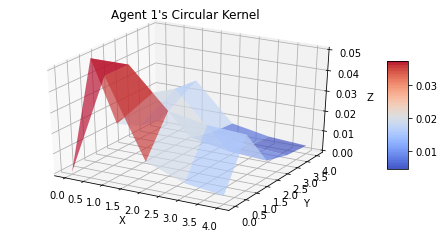

In [10]:
plot_kernel(circular_kernel(world_map, 1),'Agent 1\'s Circular Kernel')

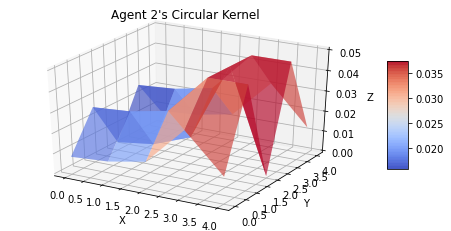

In [11]:
plot_kernel(circular_kernel(world_map, 2),'Agent 2\'s Circular Kernel')

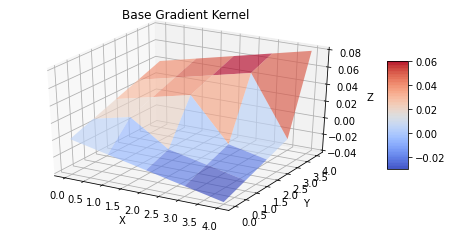

In [12]:
plot_kernel(gradient_kernel(world_map),'Base Gradient Kernel')

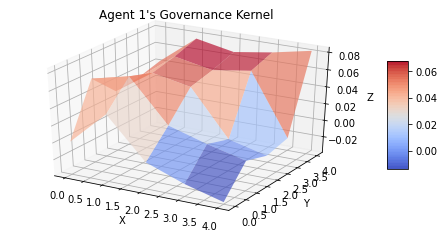

In [13]:
plot_kernel(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)),'Agent 1\'s Governance Kernel')

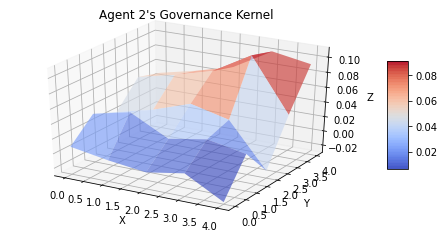

In [14]:
plot_kernel(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)),'Agent 2\'s Governance Kernel')

In [20]:
# Basic conceptual framework of the Governance Wrapper:
# * environment prior information available, like initial agent positions and corresponding gas info.,
# * environment implementation needs change, agent info. or the whole agent instance needs to be returned as well
# * iterative radial reward value decrease by a factor of 5 from initial movement step from 0.25 up until {gas/dim} boundary
# * Noise addition in the values, based on the grid size for size 3 noise factor zero, but with larger grid size, larger noise, for exploration promotion 
# * partial task completion reward, 0.25 reward value attained upon package pickup by the agent
# * prior reward shaped grid based on basic environment information whill be matched with shared observation state for new reward calculation
# * additionally, create a simple reward shaping environment that only assigns 0.25 reward value upon package pickup by the agent
class SimpleGovernanceKernelWrapper(SimpleGridRoadEnv):

    def governance_reward(self, observation, kernel, agent_name, prev_obs):
        agent_ind_x, agent_ind_y = np.where(observation == agent_name)
        prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
        prev_obs = observation # saving the previous observation state.
        # if agent is not present in the observation grid, return 0 reward.
        if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
            return 0, prev_obs
        # if agent is still at present at the previous grid position, return 0 reward.
        if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
            return 0, prev_obs
        return round(kernel[agent_ind_x[0]][agent_ind_y[0]],2), prev_obs

    def gradient_kernel(self, world_map):
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.01
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i>=j:
                    grad_kernel[i][j] = grad_unit*(i+j)
                else:
                    grad_kernel[i][j] = grad_unit*(i-j)
        return grad_kernel

    def circular_kernel(self, world_map, agent_name):
        agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.05
        # print(agent_ind_x, agent_ind_y)
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i != agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
                elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
                elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                    grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
                elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                    grad_kernel[i][j] = 0
        return grad_kernel
    
    # superposition of governance kernels for generating the effective kernel output for both the agents
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

    def __init__(self):
        super().__init__()
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.gov_kern_agent_one = np.add(gradient_kernel(self.world_start), circular_kernel(self.world_start, 1))
        self.gov_kern_agent_two = np.add(gradient_kernel(self.world_start), circular_kernel(self.world_start, 2))
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True

    def reset(self):
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True
        return super().reset()

    def step(self, action):
        next_state, reward, done, info, agent = super().step(action)
        reward_new = 0
        if agent.name == 1:
            # print(next_state, self.prev_obs_agent_one)
            reward_new, self.prev_obs_agent_one = self.governance_reward(next_state, self.gov_kern_agent_one, agent.name, self.prev_obs_agent_one)
            # print(reward_new, self.prev_obs_agent_one, agent.name)
        elif agent.name == 2:
            # print(next_state, self.prev_obs_agent_two)
            reward_new, self.prev_obs_agent_two = self.governance_reward(next_state, self.gov_kern_agent_two, agent.name, self.prev_obs_agent_two)
            # print(reward_new, self.prev_obs_agent_two, agent.name)
        # print('\n')

        if agent.package == 3 and self.preward_flag_agent_one == True and agent.name == 1:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_one = False
            # print(reward_new, agent.name)
        elif agent.package == 3 and self.preward_flag_agent_two == True and agent.name == 2:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_two = False
            # print(reward_new, agent.name)

        reward_new  = round(reward_new, 2) + reward
        return next_state, reward_new, done, info # , agent
            #, agent; will give too values to unpack error for the default stablebaselines model implementation

# Current checks, the reward shaping with kernel is working correctly,
# needs to add reward for successfully picking up the package as well.

In [21]:
# Storing obs data into simple road env for random walk testing for the environment.
import random
simple_obs_list = []
simple_info_list = []
env_simple = SimpleGovernanceKernelWrapper()
# result_test = []

for e_ in range(3):
    obs = env_simple.reset()
    for i in range(200):
        action = random.randint(0, 4) # model_simple.predict(obs)
        obs, reward, done, info = env_simple.step(action)
        # print(obs, reward, done, info) # , agent.name, agent.gas, agent.package, agent.picked)
        # print('\n')
        simple_obs_list.append(obs)
        simple_info_list.append(info)
        if done:
            print(info['state'])
            # obs = env_simple.reset()
            # result_test.append(info['state'])
            break
# Printing the output results w/ successful completions.
# result_stat = result_test.count('W') / len(result_test)
# print(f'Success rate: {result_stat * 100} %')

New episode number 1
P
New episode number 2
P
New episode number 3
P


In [22]:
# stable_baseline3 library related import statements.
from stable_baselines3.common.vec_env import DummyVecEnv # it's usage produces 'spec' related error.
from stable_baselines3.common.vec_env import SubprocVecEnv # it's usage produces 'spec' related error.
from stable_baselines3 import A2C
from stable_baselines3 import PPO

In [23]:
env_simple = SimpleGovernanceKernelWrapper()
ppo_model_simple = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_simple.learn(total_timesteps=128000, log_interval=4)

New episode number 1
New episode number 2
New episode number 3
New episode number 4
New episode number 5
New episode number 6
New episode number 7
New episode number 8
New episode number 9
New episode number 10
New episode number 11
New episode number 12
New episode number 13
New episode number 14
New episode number 15
New episode number 16
New episode number 17
New episode number 18
New episode number 19
New episode number 20
New episode number 21
New episode number 22
New episode number 23
New episode number 24
New episode number 25
New episode number 26
New episode number 27
New episode number 28
New episode number 29
New episode number 30
New episode number 31
New episode number 32
New episode number 33
New episode number 34
New episode number 35
New episode number 36
New episode number 37
New episode number 38
New episode number 39
New episode number 40
New episode number 41
New episode number 42
New episode number 43
New episode number 44
New episode number 45
New episode number 

In [24]:
# Printing the RL model instances.
print(ppo_model_simple)

In [25]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

def agent_rendering(obs_list):
    fps = 2
    nSeconds = 15
    # matching the dimension dimension of the obs_list with 'nSeconds*fps' values.
    snapshots = obs_list # [ np.random.rand(3,3) for _ in range(nSeconds*fps) ]

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(3,4) )
    colormap = colors.ListedColormap(["lightsteelblue", "chocolate", "tomato", "navajowhite", "yellowgreen", "lightpink"])
    bounds = [0,1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, colormap.N)
    a = snapshots[0]
    im = plt.imshow(a, cmap=colormap, norm=norm)
    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        im.set_array(snapshots[i])
        return [im]
    anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )
    anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
    print('Done!')

In [26]:
# Storing obs data into simple road env for ppo algorithm.
ppo_simple_obs_list = []
env_simple = SimpleGovernanceKernelWrapper()
result_test = []
obs = env_simple.reset()
for i in range(200):
    action, _states = ppo_model_simple.predict(obs)
    # print(action)
    obs, reward, done, info = env_simple.step(action)
    ppo_simple_obs_list.append(obs)
    if done:
        result_test.append(info['state'])

# Printing the output results w/ successful completions.
result_stat = result_test.count('W') / len(result_test)
print(f'Success rate: {result_stat * 100} %')

New episode number 6
New episode number 7
New episode number 8
New episode number 9
New episode number 10
New episode number 11
New episode number 12
New episode number 13
New episode number 14
New episode number 15
New episode number 16
New episode number 17
New episode number 18
New episode number 19
New episode number 20
New episode number 21
New episode number 22
New episode number 23
New episode number 24
New episode number 25
New episode number 26
New episode number 27
New episode number 28
New episode number 29
New episode number 30
New episode number 31
New episode number 32
New episode number 33
New episode number 34
New episode number 35
New episode number 36
New episode number 37
New episode number 38
New episode number 39
New episode number 40
New episode number 41
New episode number 42
New episode number 43
New episode number 44
New episode number 45
New episode number 46
New episode number 47
New episode number 48
New episode number 49
New episode number 50
New episode nu

................Done!


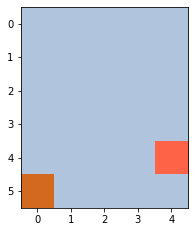

In [27]:
agent_rendering(ppo_simple_obs_list)

In [28]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/videos/result.mp4"
# Compressed video path
compressed_path = "test_anim.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=175 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# Converting the '.mp4' video into a '.gif' file.
from moviepy.editor import *
clip = (VideoFileClip("test_anim.mp4"))
clip.write_gif("video.gif")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3235840/45929032 bytes (7.0%)7176192/45929032 bytes (15.6%)11091968/45929032 bytes (24.2%)15106048/45929032 bytes (32.9%)19021824/45929032 bytes (41.4%)22798336/45929032 bytes (49.6%)26697728/45929032 bytes (58.1%)30572544/45929032 bytes (66.6%)34316288/45929032 bytes (74.7%)38027264/45929032 bytes (82.8%)41918464/45929032 bytes (91.3%)45801472/45929032 bytes (99.7%)

 98%|█████████▊| 40/41 [00:00<00:00, 102.89it/s]
